In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Data extraction

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sameerprogrammer/college-placement",  force_download=True, path = "placement-dataset.csv")

print("Path to dataset files:", path)

100%|██████████| 1.45k/1.45k [00:00<00:00, 2.29MB/s]

Path to dataset files: /root/.cache/kagglehub/datasets/sameerprogrammer/college-placement/versions/1/placement-dataset.csv


Data cleaning

In [79]:
raw_data = pd.read_csv(path)
raw_data = raw_data[['cgpa', 'iq', 'placement']]
raw_data.head()
raw_data.rename(columns={'cgpa' : 'CGPA', 'iq':'IQ', 'placement':'Placement'}, inplace=True)
raw_data.head()

,CGPA,IQ,Placement
0,6.8,123.0,1
1,5.9,106.0,0
2,5.3,121.0,0
3,7.4,132.0,1
4,5.8,142.0,0


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CGPA       100 non-null    float64
 1   IQ         100 non-null    float64
 2   Placement  100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [107]:
print(raw_data[raw_data.isnull().any(axis=1)])

Empty DataFrame
Columns: [CGPA, IQ, Placement, color]
Index: []


In [108]:
raw_data.duplicated(keep=False)

,0
0,False
1,False
2,False
3,False
4,False
...,...
95,False
96,False
97,False
98,False


In [109]:
raw_data.describe()

,CGPA,IQ,Placement
count,100.000000,100.000000,100.000000
mean,5.991000,123.580000,0.500000
std,1.143634,39.944198,0.502519
min,3.300000,37.000000,0.000000
25%,5.075000,101.500000,0.000000
50%,6.000000,127.500000,0.500000
75%,6.900000,149.000000,1.000000
max,8.500000,233.000000,1.000000


Data Visualization

In [80]:
color_map = {1: ['green', 'Placed'], 0: ['red', 'Rejected']}
raw_data['color'] = raw_data['Placement'].map(lambda x: color_map[x][0])
raw_data.head()

,CGPA,IQ,Placement,color
0,6.8,123.0,1,green
1,5.9,106.0,0,red
2,5.3,121.0,0,red
3,7.4,132.0,1,green
4,5.8,142.0,0,red


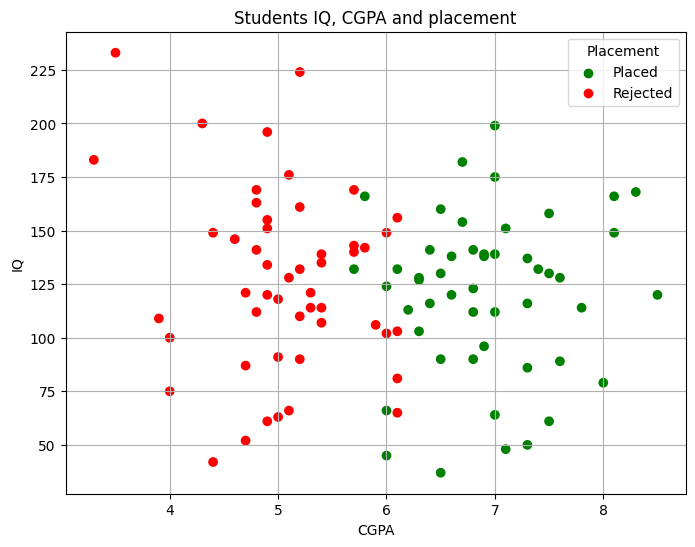

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(raw_data['CGPA'], raw_data['IQ'], c=raw_data['color'])
for category in color_map.keys():
    plt.scatter([], [], color=color_map[category][0], label=f'{color_map[category][1]}')

# Add labels and legend
plt.xlabel('CGPA')
plt.ylabel('IQ')
plt.title('Students IQ, CGPA and placement')
plt.legend(title='Placement')
plt.grid(True)
plt.show()

In [9]:
placed = raw_data[raw_data['Placement'] == 1]
placed.head()

,CGPA,IQ,Placement,color
0,6.8,123.0,1,green
3,7.4,132.0,1,green
5,7.1,48.0,1,green
10,6.0,45.0,1,green
11,6.9,138.0,1,green


In [10]:
placed.count()

,0
CGPA,50
IQ,50
Placement,50
color,50


In [11]:
not_placed = raw_data[raw_data['Placement'] == 0]
not_placed.head()

,CGPA,IQ,Placement,color
1,5.9,106.0,0,red
2,5.3,121.0,0,red
4,5.8,142.0,0,red
6,5.7,143.0,0,red
7,5.0,63.0,0,red


In [12]:
not_placed.count()

,0
CGPA,50
IQ,50
Placement,50
color,50


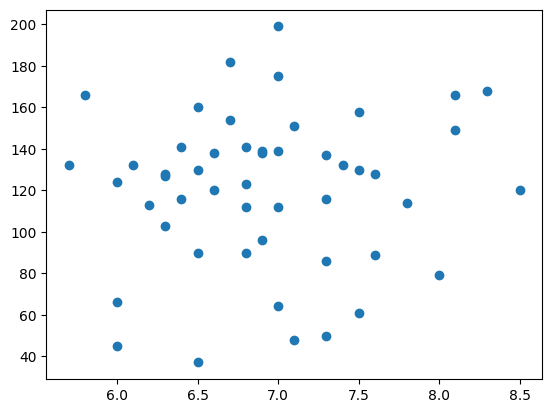

In [13]:
plt.scatter(placed['CGPA'], placed['IQ'])

Cleaning data


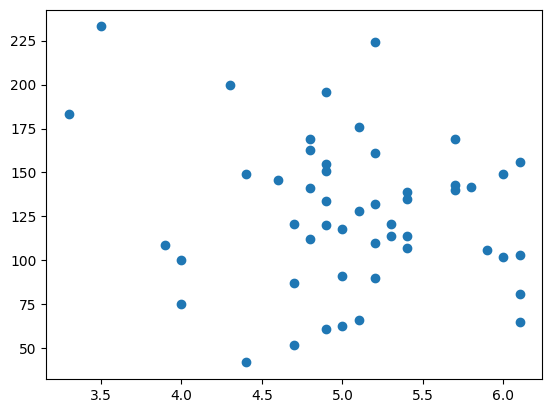

In [14]:
plt.scatter(not_placed['CGPA'], not_placed['IQ'])

In [15]:
from scipy.stats import zscore

z_scores = zscore(not_placed[['IQ','CGPA']])
abs_z_scores = abs(z_scores)
outliers = (abs_z_scores > 2.5).all(axis=1)

In [29]:
from matplotlib.lines import Line2D

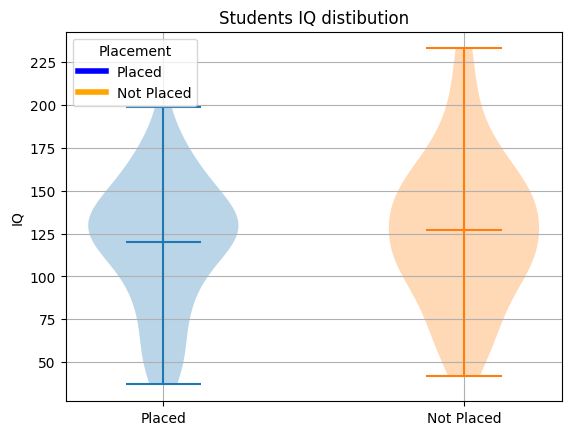

In [38]:
plt.violinplot(placed['IQ'], positions=[1], showmeans = True)
plt.violinplot(not_placed['IQ'], positions=[2], showmeans = True)

colors = ['blue', 'orange']
labels = ['Placed', 'Not Placed']
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]

plt.xticks([1, 2], labels)
plt.ylabel('IQ')
plt.title('Students IQ distibution')
plt.legend(handles, labels, title='Placement')
plt.grid(True)

plt.show()

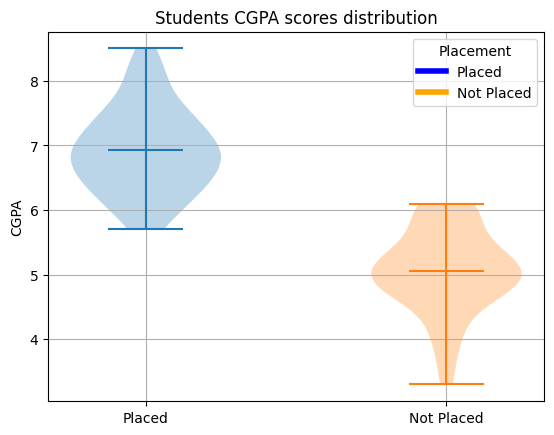

In [37]:
plt.violinplot(placed['CGPA'], positions=[1], showmeans=True)
plt.violinplot(not_placed['CGPA'], positions=[2], showmeans=True)


colors = ['blue', 'orange']
labels = ['Placed', 'Not Placed']
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]


plt.xticks([1, 2], labels)
plt.ylabel('CGPA')
plt.title('Students CGPA scores distribution')
plt.legend(handles, labels, title='Placement')
plt.grid(True)
plt.show()

As it can be seen above, IQ doesn't exert as much influence on final result as does CGPA


In [39]:
raw_data[['IQ', 'CGPA', 'Placement']].corr()

,IQ,CGPA,Placement
IQ,1.000000,-0.098791,-0.083031
CGPA,-0.098791,1.000000,0.821688
Placement,-0.083031,0.821688,1.000000


<Axes: >

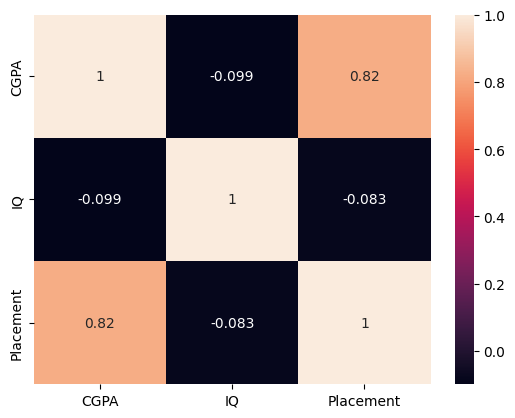

In [40]:
sns.heatmap(raw_data[['CGPA', 'IQ', 'Placement']].corr(), annot=True)

# Placement prediction

Now, let's start with trying some machine larning models to predict placement. We'll try a few models to see how they perform


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Model 01: Logistic Regression - Acurracy of 90% with 0.3/0.7

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score

lr_data = raw_data.copy()

X = lr_data[['IQ','CGPA']]
Y = lr_data['Placement']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

model = LogisticRegression(random_state=42)

In [64]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("Metrics for Logistic Regression model: \n\n")
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Metrics for Logistic Regression model: 


Accuracy: 0.9000
ROC AUC: 0.9867

Confusion Matrix:
[[14  1]
 [ 2 13]]


Model 02: K-nearest neighbor (KNN) - Accuracy of 90% with k = 10

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

knn_df = raw_data.copy()
scaler = StandardScaler()
knn_df[['IQ', 'CGPA']] = scaler.fit_transform(knn_df[['IQ', 'CGPA']])

X = knn_df[['IQ', 'CGPA']]
y = knn_df['Placement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


k_value = 10
knn_model = KNeighborsClassifier(n_neighbors=k_value)
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_test)



print("Metrics for KNN model: \n\n")
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Metrics for KNN model: 


Accuracy: 0.9000

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.93      0.87      0.90        15

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30


Confusion Matrix:
[[14  1]
 [ 2 13]]


Model 03: Support Vector Machine (SVM) - Accuracy of 96.7% with C = 1 for linear and sigmoid kernels

In [92]:
from sklearn.svm import SVC
import numpy as np

svm_data = raw_data.copy()
scaler = StandardScaler()
svm_data[['IQ', 'CGPA']] = scaler.fit_transform(svm_data[['IQ', 'CGPA']])
X = svm_data .drop(columns=['Placement', 'color'], )
y = svm_data ['Placement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [93]:
#Sigmoid Kernel

svm = SVC(kernel='sigmoid', C=1, gamma='scale')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Metrics for SVM model using sigmoid kernel: \n\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Metrics for SVM model using sigmoid kernel: 


Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.93      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
[[15  0]
 [ 1 14]]


In [101]:
#Linear Kernel

svm = SVC(kernel='linear', C=1, gamma='scale')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Metrics for SVM model using linear kernel: \n\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Metrics for SVM model using linear kernel: 


Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
[[14  1]
 [ 0 15]]


Model 04: Decicion Tree - Accuracy of 93.3% with max_depth = 3



Feature importances:  [0.88831542 0.11168458]
Metrics for Decision Tree without specified maximum depth: 


Accuracy: 1.0000

Confusion Matrix:
[[15  0]
 [ 0 15]]


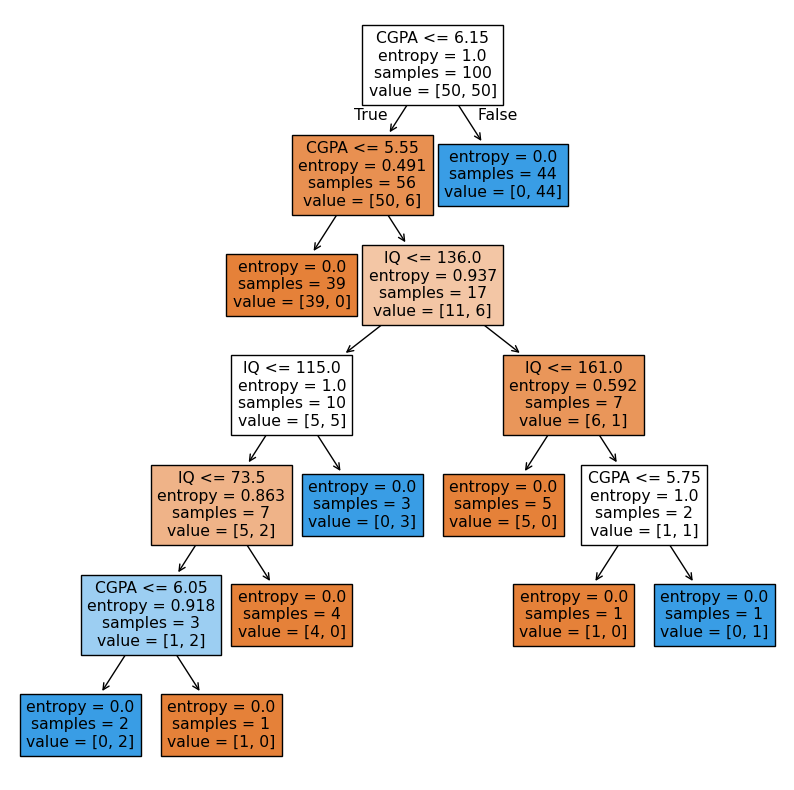

In [98]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_data = raw_data.copy()
X = tree_data[['CGPA', 'IQ']]
y = tree_data['Placement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier_model_tree = DecisionTreeClassifier(criterion = 'entropy')
classifier_model_tree.fit(X, y)
print("Feature importances: ", classifier_model_tree.feature_importances_)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_tree(classifier_model_tree , feature_names=['CGPA', 'IQ'], filled = True);

y_pred = classifier_model_tree.predict(X_test)

print("Metrics for Decision Tree without specified maximum depth: \n\n")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Feature importances:  [0.97924911 0.02075089]
Metrics for Decision Tree with maximum depth = 3: 


Accuracy: 0.9333

Confusion Matrix:
[[15  0]
 [ 2 13]]


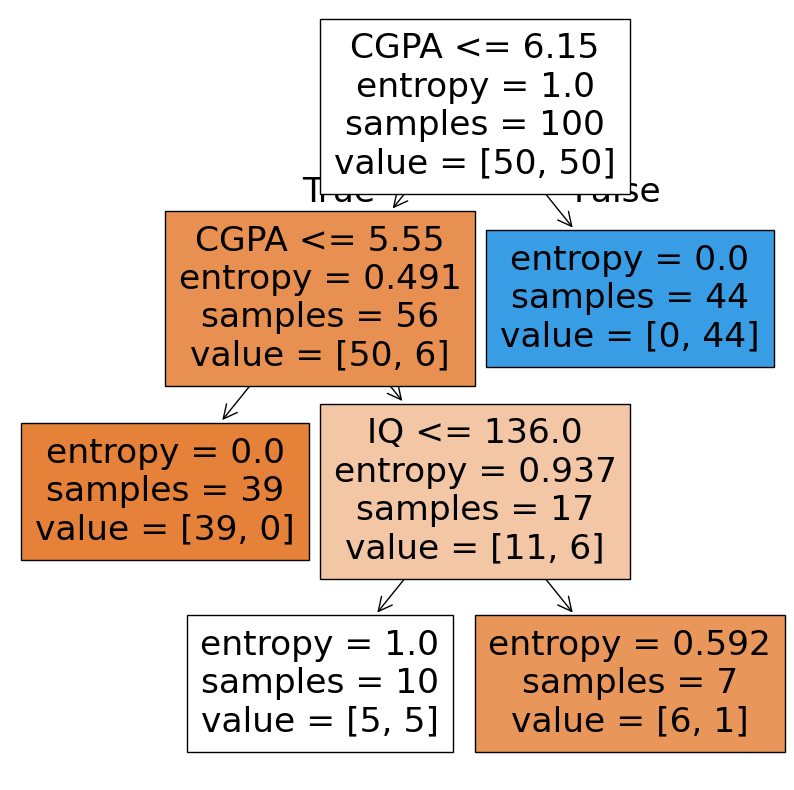

In [100]:
classifier_model_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
classifier_model_tree.fit(X, y)
print("Feature importances: ", classifier_model_tree.feature_importances_)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_tree(classifier_model_tree , feature_names=[ 'CGPA', 'IQ'], filled = True);


y_pred = classifier_model_tree.predict(X_test)
print("Metrics for Decision Tree with maximum depth = 3: \n\n")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))